# Animated graphs

# Part I — Catalog-based relations (article-driven)

### 0.1. Bootstrap (imports, paths, i18n) + animation export settings

#### Purpose of this cell

This cell initializes the notebook runtime and defines *all global controls* that affect animation rendering and export.

It merges two roles into a single, predictable “bootstrap” entry point:

1) **Infrastructure**
- imports and reusable helpers,
- project paths (topic root, processed data, animation output directory),
- theme application,
- i18n setup (labels/titles for the notebook language).

2) **Animation export configuration**
- a small set of top-level constants controlling:
  - output format (`gif` / `mp4`),
  - fps / dpi,
  - codec / bitrate for MP4,
  - writer / loop settings for GIF.

Keeping these settings in one place makes animation notebooks easy to rerun with different:
- languages (`en` / `ru`),
- themes (`light` / `dark`),
- export targets (GIF previews vs MP4 finals),

without touching the downstream plotting / rendering cells.


#### What gets defined here (global knobs)

**Animation export**
- `ANIM_FORMAT` — `"gif"` or `"mp4"` (single switch)
- `FPS`, `DPI` — common quality controls
- MP4 options: `MP4_CODEC`, `MP4_BITRATE`
- GIF options: `GIF_WRITER`, `GIF_LOOP`

**Theme**
- `THEME` — `"light"` or `"dark"` (single switch, used to apply the theme)

At the end of the cell we print the chosen values as a quick sanity check, so it’s always obvious what configuration was used to generate the outputs.

This bootstrap pattern is intentionally consistent across ANIM notebooks (ANIM_001, ANIM_002, …), enabling a uniform production workflow.

In [1]:
# =========================================================
# Cell 0 — Universal bootstrap (globals, paths, theme, i18n)
# Works for: ACAP_* and ANIM_*
# =========================================================

from __future__ import annotations

from pathlib import Path
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.io.paths import (
    get_topic_root,
    figures_dir,
    data_raw_dir,
    data_processed_dir,
    animations_dir,
)
from lulab.io.save_figure import save_fig
import lulab.io.theme as th
from astroquery.vizier import Vizier
from tqdm import tqdm
import lulab.i18n.plot_text as pt
import lulab.anim.defaults as animd
from lulab.anim.defaults import save_animation

# -----------------------------
# External services (Vizier)
# -----------------------------
# No row limit by default
Vizier.ROW_LIMIT = -1

# -----------------------------
# Global notebook constants
# -----------------------------
TOPIC: str = "TOP_0001_exoplanet_birth_radius"
NOTEBOOK: str = "ANIM_002"   # e.g. "ACAP_001", "ANIM_001"
LANG: str = "en"             # "en" / "ru"
THEME: str = "dark"          # "light" / "dark"

# -----------------------------
# Animation export settings (safe to keep for ACAP too)
# -----------------------------
ANIM_FORMAT = "mp4"       # "gif" / "mp4"
FPS = 24
DPI = 200

MP4_CODEC = "libx264"
MP4_BITRATE = 1800

GIF_WRITER = "pillow"
GIF_LOOP = 0

# sync notebook settings -> module defaults used by save_animation()
animd.ANIM_FORMAT  = ANIM_FORMAT
animd.FPS          = FPS
animd.DPI          = DPI
animd.MP4_CODEC    = MP4_CODEC
animd.MP4_BITRATE  = MP4_BITRATE
animd.GIF_LOOP     = GIF_LOOP

# --- physical limits (keep consistent) ---
AGE_MIN_GYR = 0.1
AGE_MAX_GYR = 13.5
R_SUN = 8.0  # kpc

# -----------------------------
# Common paths
# -----------------------------
TOPIC_ROOT: Path = get_topic_root(TOPIC)
FIG_DIR: Path = figures_dir(TOPIC, lang=LANG, create=True)

DATA_RAW_DIR: Path = data_raw_dir(TOPIC, create=False)
DATA_PROCESSED_DIR: Path = data_processed_dir(TOPIC, create=True)

ANIM_DIR: Path = animations_dir(TOPIC, create=True)

# --- legacy aliases (do NOT remove, used in older cells) ---
RAW  = DATA_RAW_DIR
PROC = DATA_PROCESSED_DIR

# -----------------------------
# Theme
# -----------------------------
# Use a single consistent entry point everywhere
th.apply_theme(THEME)

# -----------------------------
# Save helpers
# -----------------------------
def save_fig0(fig_id: str, *, fig):
    """
    Save figure with notebook-scoped ID to avoid collisions.

    Example:
        save_fig0("Figure_3", fig=fig)
    -> build artifact ID:
        ANIM_001_Figure_3
    """
    full_id = f"{NOTEBOOK}_{fig_id}"
    return save_fig(full_id, fig=fig, topic=TOPIC, lang=LANG)

def anim_outpath(anim_id: str, ext: str | None = None) -> Path:
    """
    Standard output path for animations.
    Example:
        out = anim_outpath("Orbit_1")  -> ANIM_DIR/ANIM_001_Orbit_1.mp4
        out = anim_outpath("Orbit_1", ext="gif")
    """
    if ext is None:
        ext = ANIM_FORMAT
    return ANIM_DIR / f"{NOTEBOOK}_{anim_id}.{ext}"

# -----------------------------
# i18n bootstrap (force reload to avoid stale imports)
# -----------------------------
importlib.reload(pt)

pt.set_lang(LANG)
if hasattr(pt, "set_notebook"):
    pt.set_notebook(NOTEBOOK)

pt.load_topic_i18n(TOPIC_ROOT, strict=True)

# convenience aliases (stable)
L = pt.L
T = pt.T

import re

def _slug(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def anim_base(name: str, *, notebook: str = NOTEBOOK) -> Path:
    """
    Returns ANIM_DIR / "<NOTEBOOK>_<slug(name)>" WITHOUT suffix.
    Use ONLY this with save_animation().
    """
    return (ANIM_DIR / f"{notebook}_{_slug(name)}")

# -----------------------------
# Quick sanity printout
# -----------------------------
print("\n--- BOOTSTRAP ---")
print("TOPIC      :", TOPIC)
print("NOTEBOOK   :", NOTEBOOK)
print("LANG       :", LANG)
print("THEME      :", THEME)
print("TOPIC_ROOT :", TOPIC_ROOT)
print("FIG_DIR    :", FIG_DIR)
print("DATA_RAW   :", DATA_RAW_DIR)
print("DATA_PROC  :", DATA_PROCESSED_DIR)
print("ANIM_DIR   :", ANIM_DIR)
print("ANIM_FORMAT:", animd.ANIM_FORMAT)
print("FPS / DPI  :", FPS, "/", DPI)


--- BOOTSTRAP ---
TOPIC      : TOP_0001_exoplanet_birth_radius
NOTEBOOK   : ANIM_002
LANG       : en
THEME      : dark
TOPIC_ROOT : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
FIG_DIR    : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en
DATA_RAW   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw
DATA_PROC  : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed
ANIM_DIR   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
ANIM_FORMAT: mp4
FPS / DPI  : 24 / 200


---

### 1. Age–Metallicity Relation ([Fe/H] vs Age)

This section contains two complementary animations visualizing the
**age–metallicity relation** using a large stellar sample (`df_age`)
prepared in the previous cell.

Both animations use the same underlying dataset and styling, but differ
in *how points are revealed over time*. Together, they provide both a
physically motivated view and an unbiased visual sanity check.


#### 1.1. Data preparation cell

In [2]:
# =========================================================
# [ANIM_002|Cell 1] Auto-find an age–metallicity table in PROC/
#   Processed CSV only (no TAP/VizieR).
#   Output: df_age with columns: age, age_err (optional), feh, feh_err (optional)
# =========================================================

import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------------
# 0) Column candidates
# -----------------------------
AGE_CANDS = ["age_gyr", "age", "Age", "AGE_GYR"]
AGE_ERR_CANDS = ["age_err", "e_age_gyr", "e_age", "e_Age", "Age_err", "eAge"]

FEH_CANDS = ["feh", "[Fe/H]", "FE_H", "fe_h", "feh_dex"]
FEH_ERR_CANDS = ["feh_err", "e_feh", "e_[Fe/H]", "e_feh_dex", "eFeH"]

def pick_col(cols: list[str], candidates: list[str]) -> str | None:
    cols_set = set(cols)
    for c in candidates:
        if c in cols_set:
            return c
    return None

# -----------------------------
# 1) Scan PROC for usable CSVs
# -----------------------------
proc_dir = Path(PROC)
csv_files = sorted(proc_dir.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {proc_dir}")

matches = []
for p in csv_files:
    try:
        # header-only read: fast
        hdr = pd.read_csv(p, nrows=0)
        cols = list(hdr.columns)

        age_col = pick_col(cols, AGE_CANDS)
        feh_col = pick_col(cols, FEH_CANDS)

        if age_col is not None and feh_col is not None:
            matches.append((p, age_col, feh_col))
    except Exception:
        # ignore unreadable CSVs
        continue

if not matches:
    # show a quick hint: which files at least have feh?
    feh_only = []
    for p in csv_files:
        try:
            cols = list(pd.read_csv(p, nrows=0).columns)
            if pick_col(cols, FEH_CANDS) is not None:
                feh_only.append(p.name)
        except Exception:
            pass

    raise RuntimeError(
        "ANIM_002: I couldn't find any processed CSV in PROC/ that contains BOTH age and [Fe/H].\n"
        f"CSV files in PROC/: {[p.name for p in csv_files]}\n"
        f"Files that contain feh-like columns (but missing age): {feh_only}\n"
        "Fix options:\n"
        "  1) Point me to the correct processed table you want to use, OR\n"
        "  2) We'll export the Boulet age catalog once into PROC/ (then ANIM_002 becomes fully offline)."
    )

print("Found candidate age–[Fe/H] tables:")
for p, a, f in matches[:10]:
    print("  -", p.name, "| age:", a, "| feh:", f)

# Prefer “age catalog”-like names if present
def score_path(p: Path) -> int:
    name = p.name.lower()
    score = 0
    if "age" in name: score += 3
    if "apogee" in name: score += 1
    if "boulet" in name or "catboost" in name: score += 2
    return score

matches = sorted(matches, key=lambda x: score_path(x[0]), reverse=True)
src_path, age_col, feh_col = matches[0]

print("\nUsing:", src_path.name)
print("  age column:", age_col)
print("  feh column:", feh_col)

# -----------------------------
# 2) Load + normalize to df_age
# -----------------------------
df = pd.read_csv(src_path)

age_err_col = pick_col(list(df.columns), AGE_ERR_CANDS)
feh_err_col = pick_col(list(df.columns), FEH_ERR_CANDS)

df_age = pd.DataFrame({
    "age": df[age_col],
    "feh": df[feh_col],
    "age_err": df[age_err_col] if age_err_col else np.nan,
    "feh_err": df[feh_err_col] if feh_err_col else np.nan,
})

for c in ["age", "age_err", "feh", "feh_err"]:
    df_age[c] = pd.to_numeric(df_age[c], errors="coerce")

# Heuristic conversion if age is log10(years)
age_med = np.nanmedian(df_age["age"].to_numpy())
if 7.5 < age_med < 10.6:
    print("Detected log10(years)-like ages; converting to Gyr.")
    df_age["age"] = (10 ** df_age["age"]) / 1e9
    # errors in log-age would be asymmetric; for animations лучше не врать
    df_age["age_err"] = np.nan

# basic physical cuts (как у тебя)
df_age = df_age.dropna(subset=["age", "feh"]).copy()
df_age = df_age[
    (df_age["age"] > 0.0) & (df_age["age"] < 14.0) &
    (df_age["feh"] > -2.0) & (df_age["feh"] < 1.0)
].copy()

print("\ndf_age rows:", len(df_age))
print("age   [min/med/max]:", float(df_age["age"].min()), float(df_age["age"].median()), float(df_age["age"].max()))
print("feh   [min/med/max]:", float(df_age["feh"].min()), float(df_age["feh"].median()), float(df_age["feh"].max()))
print("age_err available:", int(df_age["age_err"].notna().sum()), "/", len(df_age))
print("feh_err available:", int(df_age["feh_err"].notna().sum()), "/", len(df_age))

df_age.head()

Found candidate age–[Fe/H] tables:
  - boulet_apogee_ages.csv | age: age | feh: feh
  - harps_ages_grid.csv | age: age_gyr | feh: feh
  - harps_rbirth_gce.csv | age: age_gyr | feh: feh
  - sweetcat_ages_grid.csv | age: age_gyr | feh: feh
  - sweetcat_rbirth_gce.csv | age: age_gyr | feh: feh
  - sweetcat_rbirth_minchev.csv | age: age_gyr | feh: [Fe/H]
  - sweetcat_rbirth_toy.csv | age: age_gyr | feh: [Fe/H]

Using: boulet_apogee_ages.csv
  age column: age
  feh column: feh

df_age rows: 125443
age   [min/med/max]: 0.67 6.81 13.44
feh   [min/med/max]: -1.96 -0.17 0.51
age_err available: 0 / 125443
feh_err available: 0 / 125443


,age,feh,age_err,feh_err
0,5.77,-0.54,NaN,NaN
1,8.28,0.15,NaN,NaN
2,4.70,-0.24,NaN,NaN
3,8.60,-0.91,NaN,NaN
4,6.11,-0.04,NaN,NaN


---

### 1.2. Ordered reveal by stellar age

**Purpose**

Reveal the age–metallicity relation in a *physically intuitive* way:
stars appear progressively from younger to older ages.

**Key idea**

- The sample is sorted by `age`.
- At each animation frame, all stars with  
  `age ≤ current_threshold` are displayed.
- This creates a left-to-right build-up of the diagram.

**Animation structure**

- **Reveal phase (≈ 3 s)**  
  The age threshold increases linearly from the minimum to the maximum age.
- **Hold phase (≈ 3 s)**  
  The final frame remains static for comfortable viewing.

**What this shows**

- The global shape of the age–metallicity relation.
- How metal-poor and metal-rich populations populate different age ranges.
- The density evolution of the stellar population with age.

This mode is especially useful for *storytelling* and
physics-driven explanations.



Animating rows: 125443
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_age_feh_reveal.mp4
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_age_feh_reveal.mp4 exists: True


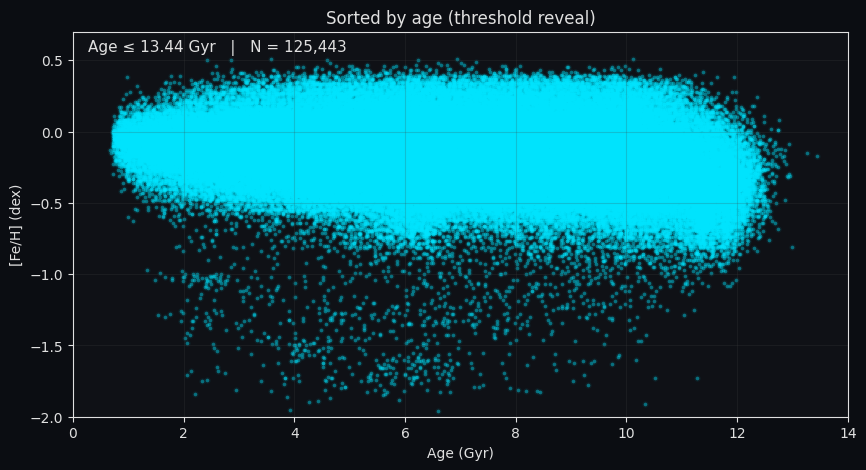

In [3]:
# =========================================================
# [ANIM_002|Cell 2] Scatter reveal: Age vs [Fe/H]
#   Uses df_age from Cell 1 (processed-only).
#   i18n + theme-safe. Output goes to ANIM_DIR via save_animation().
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) i18n text
# -----------------------------
X_AGE = L("age_gyr")
Y_FEH = L("feh")
TITLE = T("figure_1_sorted")

# Optional: if you later add notebook-specific axis labels/titles, switch to:
#   _i18n_get(T, NOTEBOOK, "....")
# For now, common is enough.

# -----------------------------
# 1) Prepare sample
# -----------------------------
SAMPLE_N = 180_000
samp = df_age.sample(min(len(df_age), SAMPLE_N), random_state=1).copy()
samp = samp.sort_values("age").reset_index(drop=True)

ages = samp["age"].astype(float).to_numpy()
feh  = samp["feh"].astype(float).to_numpy()

print("Animating rows:", len(samp))

# -----------------------------
# 2) Figure styling
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 5))  # ~16:9 like other anims
ax.grid(True, alpha=0.22)

ax.set_xlim(0, 14)
ax.set_ylim(-2.0, 0.7)
ax.set_xlabel(X_AGE)
ax.set_ylabel(Y_FEH)
ax.set_title(TITLE)

# Color choice: keep simple + readable in both themes
POINT_COLOR = "#00e5ff" if str(THEME).lower() == "dark" else "tab:blue"

sc_glow = ax.scatter([], [], s=22, alpha=0.06, c=POINT_COLOR, linewidths=0)
sc      = ax.scatter([], [], s=7,  alpha=0.42, c=POINT_COLOR, linewidths=0)

txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=11,
)

# -----------------------------
# 3) Animation timing (3 sec reveal + 3 sec hold)
# -----------------------------
REVEAL_SEC = 3
HOLD_SEC   = 3
N_FRAMES_REVEAL = int(FPS * REVEAL_SEC)
N_FRAMES_HOLD   = int(FPS * HOLD_SEC)
N_FRAMES        = max(2, N_FRAMES_REVEAL + N_FRAMES_HOLD)

age_min, age_max = float(np.nanmin(ages)), float(np.nanmax(ages))

def init():
    empty = np.empty((0, 2))
    sc.set_offsets(empty)
    sc_glow.set_offsets(empty)
    txt.set_text("")
    return sc_glow, sc, txt

def update(frame):
    # Reveal phase: progress 0..1 for first N_FRAMES_REVEAL frames
    if frame < N_FRAMES_REVEAL:
        t = frame / max(1, (N_FRAMES_REVEAL - 1))
        thr = age_min + t * (age_max - age_min)
    else:
        thr = age_max

    k = np.searchsorted(ages, thr, side="right")
    offsets = np.column_stack([ages[:k], feh[:k]])

    sc.set_offsets(offsets)
    sc_glow.set_offsets(offsets)

    # i18n-safe corner text (numbers are universal)
    txt.set_text(f"Age ≤ {thr:4.2f} Gyr   |   N = {k:,}")
    return sc_glow, sc, txt

ani = FuncAnimation(
    fig, update, init_func=init,
    frames=N_FRAMES,
    interval=1000 / FPS,
    blit=True
)

# -----------------------------
# 4) Save
# -----------------------------
save_animation(ani, anim_base("age_feh_reveal"))
plt.show()

---

### Cell 1b — Random reveal (order-free control)

**Purpose**

Demonstrate that the observed structure is **intrinsic to the data** and
not an artifact of the reveal order.

**Key idea**

- All stars are randomly permuted once (fixed random seed).
- Points are revealed in random batches, independent of age or metallicity.

**Animation structure**

- **Reveal phase (≈ 3 s)**  
  Random subsets of stars are added at each frame.
- **Hold phase (≈ 3 s)**  
  The complete distribution remains visible.

**What this shows**

- The same global cloud structure appears even without ordered revealing.
- Confirms that trends seen in the ordered animation are not visually induced.
- Serves as a robustness / sanity-check visualization.



Animating rows (random): 125443
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_age_feh_reveal_random.mp4
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_age_feh_reveal_random.mp4 exists: True


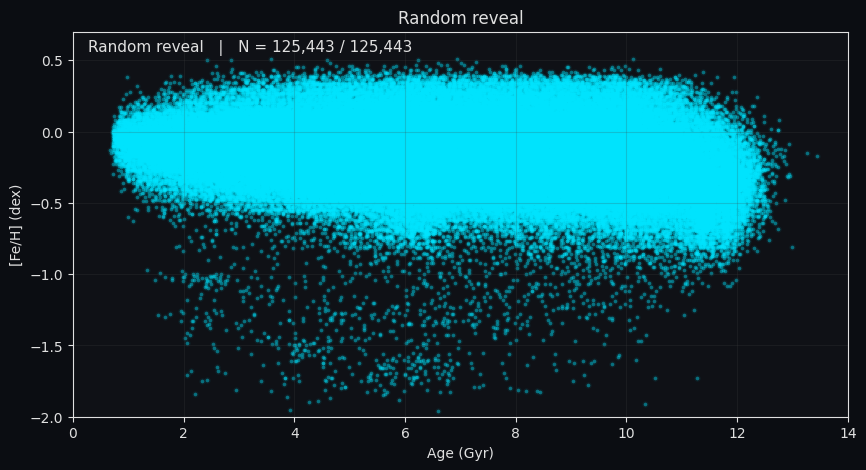

In [4]:
# =========================================================
# [ANIM_002|Cell 2b] Scatter reveal: Age vs [Fe/H] (RANDOM order)
#   Uses the same df_age sample.
#   3 sec reveal + 3 sec hold.
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 0) i18n text
# -----------------------------
X_AGE = L("age_gyr")
Y_FEH = L("feh")
TITLE = T("figure_1_random")

# -----------------------------
# 1) Prepare sample (same logic as your LR/age-threshold anim)
# -----------------------------
SAMPLE_N = 180_000
samp = df_age.sample(min(len(df_age), SAMPLE_N), random_state=1).copy()

ages = samp["age"].astype(float).to_numpy()
feh  = samp["feh"].astype(float).to_numpy()

# Drop any non-finite just in case
m = np.isfinite(ages) & np.isfinite(feh)
ages, feh = ages[m], feh[m]

N = len(ages)
print("Animating rows (random):", N)

# -----------------------------
# 2) Figure styling
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 5))  # ~16:9
ax.grid(True, alpha=0.22)

ax.set_xlim(0, 14)
ax.set_ylim(-2.0, 0.7)
ax.set_xlabel(X_AGE)
ax.set_ylabel(Y_FEH)
ax.set_title(TITLE)

POINT_COLOR = "#00e5ff" if str(THEME).lower() == "dark" else "tab:blue"

sc_glow = ax.scatter([], [], s=22, alpha=0.06, c=POINT_COLOR, linewidths=0)
sc      = ax.scatter([], [], s=7,  alpha=0.42, c=POINT_COLOR, linewidths=0)

txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=11,
)

# -----------------------------
# 3) Animation timing (3 sec reveal + 3 sec hold)
# -----------------------------
REVEAL_SEC = 3
HOLD_SEC   = 3
N_FRAMES_REVEAL = int(FPS * REVEAL_SEC)
N_FRAMES_HOLD   = int(FPS * HOLD_SEC)
N_FRAMES        = max(2, N_FRAMES_REVEAL + N_FRAMES_HOLD)

# Random order (stable with seed)
seed = 2
rng = np.random.default_rng(seed)
order = rng.permutation(N)

# We reveal in batches so it finishes exactly in REVEAL_SEC
points_per_frame = int(np.ceil(N / max(1, N_FRAMES_REVEAL)))

# Storage for already-revealed points
xs, ys = [], []

def init():
    empty = np.empty((0, 2))
    sc.set_offsets(empty)
    sc_glow.set_offsets(empty)
    txt.set_text("")
    return sc_glow, sc, txt

def update(frame):
    # Reveal phase
    if frame < N_FRAMES_REVEAL:
        start = frame * points_per_frame
        end   = min((frame + 1) * points_per_frame, N)

        if start < end:
            idx = order[start:end]
            xs.extend(ages[idx].tolist())
            ys.extend(feh[idx].tolist())

        k = len(xs)
        offsets = np.column_stack([xs, ys]) if k else np.empty((0, 2))

    # Hold phase
    else:
        k = len(xs)
        offsets = np.column_stack([xs, ys]) if k else np.empty((0, 2))

    sc.set_offsets(offsets)
    sc_glow.set_offsets(offsets)

    # Corner text
    txt.set_text(f"Random reveal   |   N = {k:,} / {N:,}")
    return sc_glow, sc, txt

ani_rand = FuncAnimation(
    fig, update, init_func=init,
    frames=N_FRAMES,
    interval=1000 / FPS,
    blit=True
)

# -----------------------------
# 4) Save
# -----------------------------
save_animation(ani_rand, anim_base("age_feh_reveal_RANDOM"))
plt.show()

### Design notes

- Both animations:
  - Use identical axis limits and styling.
  - Are fully **i18n-safe** (labels and titles via `L` / `T`).
  - Respect the global theme and animation settings from the bootstrap cell.
- A faint “glow” scatter layer is used to improve density perception,
  especially in dark theme.
- Output is saved via the unified `save_animation()` helper into `ANIM_DIR`.

Together, these two animations provide a clear, robust, and publication-ready
visualization of the age–metallicity relation.

---

# Part II — Reconstructed quantities and derived relations

This part of the notebook will create animations of the galaxy disc with metallicity gradients and stellar populations.

### 2.1. Inside-out growth of the Galactic disk  

**APOGEE × Gaia metallicity gradient with binned statistics**

This animation visualizes the **inside-out formation of the Galactic disk** using a large APOGEE × Gaia sample, shown in the plane of **Galactocentric radius** \(R\) versus **metallicity** \([\mathrm{Fe/H}]\).

The animation proceeds by gradually increasing the maximum displayed radius \(R_{\max}\), mimicking the idea that the inner disk forms first and the outer disk is populated later. At each animation frame:

- **Individual stars** are revealed as a point cloud for all stars with \(R \le R_{\max}\).
- A **global linear metallicity gradient** is overplotted and extrapolated toward the Galactic center, providing a reference for the large-scale radial trend.
- **Binned statistics** are computed within fixed radial bins:
  - the **median metallicity** in each bin,
  - and the **16th–84th percentile range**, representing the intrinsic scatter.

Only bins containing a sufficient number of stars are shown, ensuring that the median trend and scatter band reflect statistically robust regions of the disk.

The animation concludes with a short **static hold**, allowing the final configuration—point distribution, median relation, and metallicity corridor—to be inspected without motion.

Overall, this figure illustrates how the observed present-day metallicity gradient of the Milky Way disk can be interpreted as the outcome of **inside-out growth**, with increasing radial extent accompanied by systematic changes in chemical enrichment.

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_insideoutgrowth_withmedian.mp4
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_insideoutgrowth_withmedian.mp4 exists: True


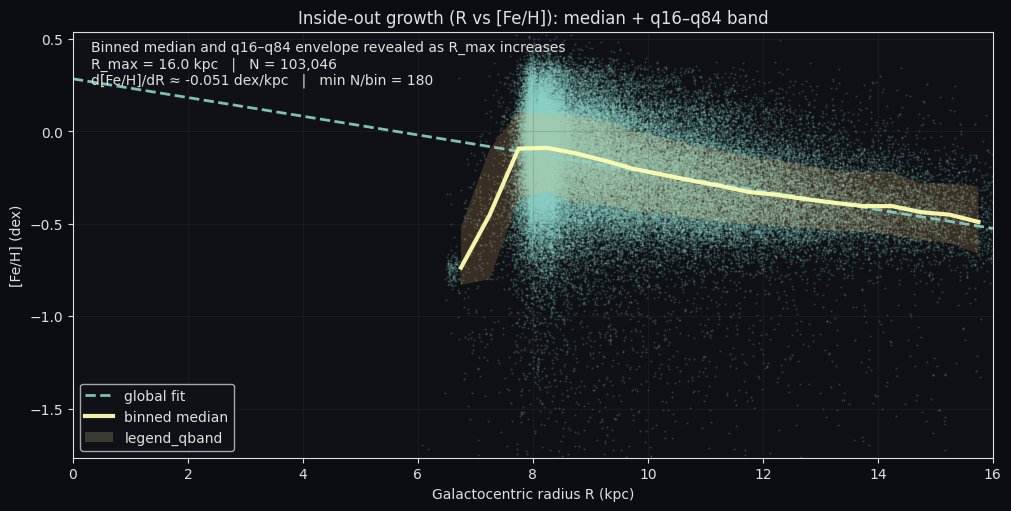

In [5]:
# =========================================================
# [ANIM_002|A+] Inside-out growth reveal:
#   APOGEE×Gaia: point cloud + binned median + q16–q84 band
#   Revealed with increasing R_max + 3s hold at the end
#   New architecture: processed CSV only + i18n-safe
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# i18n text
# -----------------------------
X_R   = L("R_gal")
Y_FEH = L("feh")

TITLE    = T("figure_2")
SUBTITLE = T("figure_2_caption")

LEG_FIT  = L("legend_global_fit")
LEG_MED  = L("legend_binned_median")
LEG_BAND = L("legend_qband")

# -----------------------------
# Helper: binned stats
# -----------------------------
def _binned_stats(x, y, bins, min_n=150):
    """
    Returns:
      xcent, med, q16, q84, n
    with NaNs where n < min_n.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    nb = len(bins) - 1
    xcent = 0.5 * (bins[:-1] + bins[1:])
    med = np.full(nb, np.nan)
    q16 = np.full(nb, np.nan)
    q84 = np.full(nb, np.nan)
    n = np.zeros(nb, dtype=int)

    for i in range(nb):
        m = (x >= bins[i]) & (x < bins[i + 1])
        n[i] = int(m.sum())
        if n[i] >= min_n:
            yy = y[m]
            med[i] = np.nanmedian(yy)
            q16[i] = np.nanquantile(yy, 0.16)
            q84[i] = np.nanquantile(yy, 0.84)

    return xcent, med, q16, q84, n

# -----------------------------
# Main animation
# -----------------------------
def animate_inside_out_growth_with_median(
    df,
    *,
    r_col="R_gal",
    feh_col="feh",
    rmax_final=16.0,
    rmax_start=2.0,
    bins=np.arange(0, 16.0 + 0.5, 0.5),
    min_bin_n=180,
    reveal_sec=3,
    hold_sec=3,
    show_fit=True,
    show_band=True,
):
    d = df[[r_col, feh_col]].dropna().copy()
    d = d[(d[r_col] >= 0) & (d[r_col] <= rmax_final)].copy()

    r = d[r_col].to_numpy(dtype=float)
    feh = d[feh_col].to_numpy(dtype=float)

    # global linear fit (full dataset)
    m_fit, b_fit = np.polyfit(r, feh, 1)

    # stable axes
    xlim = (0.0, rmax_final)
    ylo, yhi = np.quantile(feh, [0.002, 0.998])
    pad = 0.08 * (yhi - ylo)
    ylim = (ylo - pad, yhi + pad)

    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(X_R)
    ax.set_ylabel(Y_FEH)
    ax.set_title(TITLE)
    ax.grid(alpha=0.2)

    # artists
    sc = ax.scatter([], [], s=2, alpha=0.25, linewidths=0)

    fit_line, = ax.plot([], [], linestyle="--", linewidth=2, alpha=0.9, label=LEG_FIT)
    med_line, = ax.plot([], [], linewidth=3, alpha=0.95, label=LEG_MED)

    band = None
    if show_band:
        band = ax.fill_between([], [], [], alpha=0.18, label=LEG_BAND)

    txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left")

    ax.legend(loc="lower left", frameon=True)

    # timing
    frames_reveal = max(2, int(FPS * reveal_sec))
    frames_hold = max(1, int(FPS * hold_sec))
    frames_total = frames_reveal + frames_hold

    def ease01(t):
        # cosine ease-in-out
        t = np.clip(t, 0, 1)
        return 0.5 - 0.5 * np.cos(np.pi * t)

    def frame_rmax(i):
        # rmax grows only during reveal; then stays at final during hold
        if i >= frames_reveal:
            return float(rmax_final)
        t = i / (frames_reveal - 1)
        return float(rmax_start + (rmax_final - rmax_start) * ease01(t))

    def init():
        sc.set_offsets(np.empty((0, 2)))
        fit_line.set_data([], [])
        med_line.set_data([], [])
        txt.set_text("")
        return []

    def update(i):
        nonlocal band
        rmax_t = frame_rmax(i)
        mask = r <= rmax_t

        pts = np.column_stack([r[mask], feh[mask]])
        sc.set_offsets(pts)

        # global fit, extrapolated to R=0
        if show_fit:
            xfit = np.linspace(0.0, rmax_t, 200)
            yfit = m_fit * xfit + b_fit
            fit_line.set_data(xfit, yfit)
        else:
            fit_line.set_data([], [])

        # binned stats for revealed subset
        xcent, med, q16, q84, n = _binned_stats(r[mask], feh[mask], bins=bins, min_n=min_bin_n)

        inside = xcent <= rmax_t
        xshow = xcent[inside]
        med_show = med[inside]
        q16_show = q16[inside]
        q84_show = q84[inside]

        med_line.set_data(xshow, med_show)

        if show_band:
            try:
                band.remove()
            except Exception:
                pass
            band = ax.fill_between(xshow, q16_show, q84_show, alpha=0.18)

        txt.set_text(
            f"{SUBTITLE}\n"
            f"R_max = {rmax_t:4.1f} kpc   |   N = {mask.sum():,}\n"
            f"d[Fe/H]/dR ≈ {m_fit:+.3f} dex/kpc   |   min N/bin = {min_bin_n}"
        )

        return []

    anim = FuncAnimation(fig, update, init_func=init, frames=frames_total, interval=1000 / FPS, blit=False)
    return anim, fig

# -----------------------------
# Load data (processed-only) + run
# -----------------------------
DATA_CSV = PROC / "apogee_gaia_fehr_R.csv"
df_rg_feh = pd.read_csv(DATA_CSV)

animA2, figA2 = animate_inside_out_growth_with_median(
    df_rg_feh,
    r_col="R_gal",
    feh_col="feh",
    rmax_final=16.0,
    rmax_start=2.0,
    bins=np.arange(0, 16.0 + 0.5, 0.5),
    min_bin_n=180,
    reveal_sec=3,
    hold_sec=3,
    show_fit=True,
    show_band=True,
)

save_animation(animA2, anim_base("InsideOutGrowth_WithMedian"))
plt.show()

---

## 2.2. Inside-out growth: vertical profile (R–Z)

This animation shows the **inside-out build-up of the Galactic disk** in a *vertical profile view*, using an APOGEE×Gaia stellar sample.

### What is shown

- **Horizontal axis:** Galactocentric radius $R_{\rm gal}$ (kpc)  
- **Vertical axis:** Height above/below the Galactic plane $Z$ (kpc)  
- **Color:** Stellar metallicity $[\mathrm{Fe/H}]$

Each frame reveals stars only up to a gradually increasing maximum radius $R_{\max}$, mimicking the **radial growth of the disk over time**.

### Data handling

- The input is a **processed APOGEE×Gaia catalog** containing at least:
  - sky coordinates (RA, Dec),
  - parallax (mas),
  - metallicity $[\mathrm{Fe/H}]$.
- Galactocentric cylindrical coordinates $(R_{\rm gal}, Z)$ are **recomputed explicitly** in this cell using `astropy`:
  - this avoids relying on pre-computed proxy columns,
  - and guarantees a physically meaningful vertical structure.

Basic quality cuts are applied:
- positive parallaxes,
- reasonable heliocentric distances,
- bounded metallicity range,
- $R_{\rm gal} \leq 18$kpc and $|Z| \leq 3$ kpc for visual clarity.

### Animation logic

- At each frame, a smooth **ease-in–out function** increases the allowed maximum radius from
  $R_{\rm start} = 2$ kpc to $R_{\rm final} = 16$ kpc.
- Only stars with $R_{\rm gal} \le R_{\max}$ are shown.
- This produces a characteristic **fan-like opening** of the disk:
  - inner regions appear first,
  - outer regions fill in later,
  - vertical thickening and metallicity gradients emerge naturally.

### Why this view matters

Compared to a simple $R$–$[\mathrm{Fe/H}]$ diagram, the $R$–$Z$ profile:

- makes the **vertical structure of the disk** explicit,
- highlights the coexistence of thin and thick components,
- visually connects **metallicity gradients** with disk geometry,
- and provides an intuitive picture of **inside-out disk formation**.

The result is a compact, physically interpretable animation that complements the radial and age-based views shown earlier in the notebook.

Source: apogee_ready.csv | rows after basic cuts: 103602
Prepared for animation: 102431
Z_gal quantiles: {0.01: -2.1001371405026545, 0.5: -0.08420035508491167, 0.99: 1.832751234263061}
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_profile_insideout_rz.mp4
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_profile_insideout_rz.mp4 exists: True


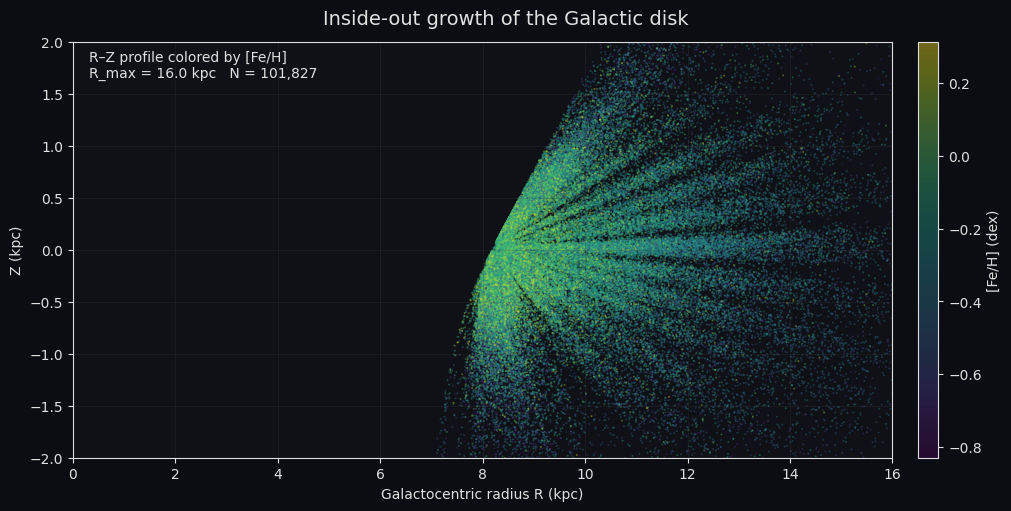

In [6]:
# =========================================================
# [ANIM_002|Cell 3] Profile view: inside-out reveal in (R_gal, Z_gal) colored by [Fe/H]
#   Source: processed APOGEE×Gaia with ra/dec/plx_mas/feh (we recompute Galactocentric coords).
#   i18n + theme-safe. Output -> ANIM_DIR via save_animation().
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from astropy import units as u
from astropy.coordinates import SkyCoord, Galactocentric

# -----------------------------
# 0) Load processed source
# -----------------------------
SRC_PATH = PROC / "apogee_ready.csv"   # has ra/dec/plx_mas/feh
if not SRC_PATH.exists():
    # fallback option if you prefer
    SRC_PATH = PROC / "apogee_gaia_fehr_R.csv"

if not SRC_PATH.exists():
    raise FileNotFoundError(f"ANIM_002 Cell 3: missing source CSV in PROC: {SRC_PATH.name}")

src = pd.read_csv(SRC_PATH)

need = {"ra", "dec", "plx_mas", "feh"}
miss = need - set(src.columns)
if miss:
    raise RuntimeError(
        f"ANIM_002 Cell 3: source lacks required columns {miss}. "
        f"Source={SRC_PATH.name} cols={list(src.columns)[:40]}..."
    )

# numeric sanitize
d = src.copy()
for c in ["ra", "dec", "plx_mas", "feh"]:
    d[c] = pd.to_numeric(d[c], errors="coerce")

d = d.dropna(subset=["ra", "dec", "plx_mas", "feh"]).copy()
d = d[d["plx_mas"] > 0].copy()

# dist in kpc (plx_mas in mas)
d["dist_kpc"] = 1.0 / d["plx_mas"]
d = d[(d["dist_kpc"] > 0.05) & (d["dist_kpc"] < 10.0)].copy()

# metallicity sanity cut
d = d[(d["feh"] >= -2.5) & (d["feh"] <= 1.0)].copy()

print("Source:", SRC_PATH.name, "| rows after basic cuts:", len(d))

# -----------------------------
# 1) Recompute Galactocentric coords -> R_gal, Z_gal
# -----------------------------
# These are standard-ish values; adjust if you want consistency with a specific paper.
R0 = 8.2 * u.kpc
Z0 = 0.0208 * u.kpc

c_icrs = SkyCoord(
    ra=d["ra"].to_numpy() * u.deg,
    dec=d["dec"].to_numpy() * u.deg,
    distance=d["dist_kpc"].to_numpy() * u.kpc,
    frame="icrs",
)
gc_frame = Galactocentric(galcen_distance=R0, z_sun=Z0)
c_gc = c_icrs.transform_to(gc_frame)

x = c_gc.x.to_value(u.kpc)
y = c_gc.y.to_value(u.kpc)
z = c_gc.z.to_value(u.kpc)

d["R_gal"] = np.sqrt(x * x + y * y)
d["Z_gal"] = z

# final cuts for plot clarity
d = d[(d["R_gal"] >= 0) & (d["R_gal"] <= 18)].copy()
d = d[(np.abs(d["Z_gal"]) <= 3.0)].copy()

print("Prepared for animation:", len(d))
print("Z_gal quantiles:", d["Z_gal"].quantile([0.01, 0.5, 0.99]).to_dict())

# -----------------------------
# 2) i18n text
# -----------------------------
X_R    = L("R_gal")
Y_Z    = L("z_kpc") if callable(L) and L("z_kpc") != "z_kpc" else "Z (kpc)"
CB_FEH = L("feh")

TITLE    = T("figure_3")
SUBTITLE = T("figure_3_caption")

# -----------------------------
# 3) Animation: inside-out reveal in (R, Z), colored by [Fe/H]
# -----------------------------
def animate_profile_inside_out(
    df: pd.DataFrame,
    *,
    frames: int = 150,
    rmax_start: float = 2.0,
    rmax_final: float = 16.0,
    zlim: float = 2.0,
    title: str = "",
    subtitle: str = "",
):
    r = df["R_gal"].to_numpy()
    z = df["Z_gal"].to_numpy()
    feh = df["feh"].to_numpy()

    # robust color scale
    vmin, vmax = np.quantile(feh, [0.01, 0.99])

    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

    # TITLE: figure-level (НЕ ax.set_title)
    if title:
        fig.suptitle(title, fontsize=14)

    ax.set_xlim(0, rmax_final)
    ax.set_ylim(-zlim, zlim)
    ax.set_xlabel(X_R)
    ax.set_ylabel(Y_Z)
    ax.grid(alpha=0.2)

    sc = ax.scatter([], [], c=[], s=2, alpha=0.40, cmap="viridis", vmin=vmin, vmax=vmax, linewidths=0)
    cb = fig.colorbar(sc, ax=ax, pad=0.02)
    cb.set_label(CB_FEH)

    # SUBTITLE: inside axes, top-left (отдельно от title)
    subtitle_artist = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left")

    def rmax_at(i):
        t = i / (frames - 1)
        t2 = 0.5 - 0.5 * np.cos(np.pi * t)  # ease-in-out
        return rmax_start + (rmax_final - rmax_start) * t2

    def init():
        sc.set_offsets(np.empty((0, 2)))
        sc.set_array(np.array([]))
        subtitle_artist.set_text("")
        return (sc, subtitle_artist)

    def update(i):
        rmax_t = rmax_at(i)
        m = (r <= rmax_t)

        pts = np.column_stack([r[m], z[m]])
        sc.set_offsets(pts)
        sc.set_array(feh[m])

        if subtitle:
            subtitle_artist.set_text(f"{subtitle}\nR_max = {rmax_t:4.1f} kpc   N = {m.sum():,}")
        else:
            subtitle_artist.set_text(f"R_max = {rmax_t:4.1f} kpc   N = {m.sum():,}")

        return (sc, subtitle_artist)

    anim = FuncAnimation(fig, update, init_func=init, frames=frames, interval=1000 / FPS, blit=True)
    return anim, fig

animB, figB = animate_profile_inside_out(
    d,
    frames=150,
    rmax_start=2.0,
    rmax_final=16.0,
    zlim=2.0,
    title=TITLE,
    subtitle=SUBTITLE,
)

save_animation(animB, anim_base("Profile_InsideOut_RZ"))
plt.show()

---

## Conclusion

In this notebook (**ANIM_002**) we built a fully self-contained, reproducible animation pipeline based exclusively on **processed datasets**, without any direct dependence on external services or on-the-fly catalog queries.

### What was achieved

- **Unified data architecture**  
  All animations rely on pre-computed CSV tables produced earlier in the project.  
  This makes the notebook:
  - deterministic,
  - fast to execute,
  - robust against upstream API or catalog changes.

- **Age–metallicity relation (Age vs [Fe/H])**  
  We visualized the gradual build-up of the age–metallicity distribution using animated point reveals:
  - a monotonic (age-ordered) reveal highlighting the temporal sequence,
  - a random reveal serving as a control to verify that perceived structure is not an animation artifact.

- **Inside-out growth of the Galactic disk**  
  Using the APOGEE × Gaia sample, we demonstrated how stellar populations appear progressively at larger Galactocentric radii:
  - first as a raw point cloud,
  - then augmented with **binned medians and inter-quantile (q16–q84) envelopes**, revealing the underlying metallicity gradient and its intrinsic scatter.

- **Edge-on (R–Z) Galactic profile**  
  By projecting stars into the Galactocentric *(R, Z)* plane and animating the radial build-up, we effectively visualized the Milky Way **as seen edge-on**, with metallicity encoded by color.  
  This representation makes the disk structure and vertical extent immediately apparent and provides intuitive physical context.

- **Internationalization (i18n) integration**  
  All labels, titles, and legends are now sourced from YAML-based i18n files, with safe fallbacks.  
  This ensures:
  - consistent terminology across figures,
  - effortless switching between languages,
  - long-term maintainability as the project grows.

### Scope and boundaries

This notebook intentionally focuses on **physically motivated, literature-anchored visualizations** that directly support the scientific narrative.  
More speculative or exploratory visual experiments have been deliberately moved to **ANIM_003**, keeping this notebook clean, interpretable, and publication-ready.

**ANIM_002** now serves as a stable reference implementation for:
- animated exploration of Galactic chemical evolution,
- inside-out disk growth,
- and best practices in data-driven astrophysical visualization.

---